## Базовая обработка таблицы

In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as snss
from scipy import stats
from datetime import datetime
import seaborn as sns

In [446]:
raw_data = pd.read_csv('D:/access_log_202305221315.csv')
DF = raw_data.copy()

In [447]:
DF

,dt,tme,host,uri,uuid,http_referer
0,2023-03-17,2023-03-17 05:55:10,www.drom.ru,/reviews/,6AAAA5C6D9142BB6FFE942D1F5472FDC8,https://my.drom.ru/personal/messaging-modal/di...
1,2023-03-17,2023-03-17 13:50:37,www.drom.ru,/reviews/add/,BD39005A2C820F1D3451F40CDA98DFF19,https://www.drom.ru/reviews/mitsubishi/galant/
2,2023-03-20,2023-03-19 16:32:42,www.drom.ru,/reviews/,B6FB06DEF3CC3558F9AFD68D4154A5520,https://www.drom.ru/
3,2023-03-20,2023-03-19 16:37:11,www.drom.ru,/reviews/genesis/,B6FB06DEF3CC3558F9AFD68D4154A5520,https://www.drom.ru/reviews/
4,2023-03-20,2023-03-19 16:37:17,www.drom.ru,/reviews/genesis/,B6FB06DEF3CC3558F9AFD68D4154A5520,https://www.drom.ru/reviews/
...,...,...,...,...,...,...
207903,2023-03-14,2023-03-14 11:12:10,www.drom.ru,/reviews/,9B81E5A9A1289F3D3500DDC9D26FE41C3,https://www.drom.ru/
207904,2023-03-14,2023-03-14 09:55:36,www.drom.ru,/reviews/mitsubishi/,F52E431DFF91462574AA7DE81AA72B2A9,https://www.drom.ru/reviews/
207905,2023-03-14,2023-03-14 09:55:22,www.drom.ru,/reviews/,F52E431DFF91462574AA7DE81AA72B2A9,https://vladivostok.drom.ru/mitsubishi/pajero_...
207906,2023-03-14,2023-03-13 19:34:27,www.drom.ru,/reviews/infiniti/,4E7FA6AB2779C12B5739A6BBB7CA86553,NaN


In [448]:
DF = DF.drop(columns=['dt', 'host'], axis=1) # Создаём новый df без столбцов с датой выгрызки на сервер и именем хоста

In [449]:
#создаем столбец с флагом группы пользователя: 0 - контрольная группа, 1 - тестовая группа
DF['group'] = DF['uuid'].apply(lambda x: int(x,base=16)) % 2 

In [450]:
DF['tme'] = DF['tme'].astype('datetime64')

In [451]:
DF['tme']

0        2023-03-17 05:55:10
1        2023-03-17 13:50:37
2        2023-03-19 16:32:42
3        2023-03-19 16:37:11
4        2023-03-19 16:37:17
                 ...        
207903   2023-03-14 11:12:10
207904   2023-03-14 09:55:36
207905   2023-03-14 09:55:22
207906   2023-03-13 19:34:27
207907   2023-03-13 21:43:25
Name: tme, Length: 207908, dtype: datetime64[ns]

In [452]:
DF = DF.drop_duplicates()

In [453]:
DF["date"] = DF["tme"].dt.to_period("D") # добавление столбца только с датой без времени, для более удобной группировки

In [454]:
DF = DF[(DF.date <= '2023-03-17') & (DF.date != '2023-03-10')]

In [455]:
DF

,tme,uri,uuid,http_referer,group,date
0,2023-03-17 05:55:10,/reviews/,6AAAA5C6D9142BB6FFE942D1F5472FDC8,https://my.drom.ru/personal/messaging-modal/di...,0,2023-03-17
1,2023-03-17 13:50:37,/reviews/add/,BD39005A2C820F1D3451F40CDA98DFF19,https://www.drom.ru/reviews/mitsubishi/galant/,1,2023-03-17
14,2023-03-12 20:56:22,/reviews/,15006932BBE8D02FF0A2D2A39133B6522,NaN,0,2023-03-12
26,2023-03-17 04:33:00,/reviews/opel/,F19346725C61AAC55BA962D2225A8A872,https://www.drom.ru/reviews/,0,2023-03-17
27,2023-03-17 04:32:54,/reviews/,F19346725C61AAC55BA962D2225A8A872,https://www.drom.ru/,0,2023-03-17
...,...,...,...,...,...,...
207903,2023-03-14 11:12:10,/reviews/,9B81E5A9A1289F3D3500DDC9D26FE41C3,https://www.drom.ru/,1,2023-03-14
207904,2023-03-14 09:55:36,/reviews/mitsubishi/,F52E431DFF91462574AA7DE81AA72B2A9,https://www.drom.ru/reviews/,1,2023-03-14
207905,2023-03-14 09:55:22,/reviews/,F52E431DFF91462574AA7DE81AA72B2A9,https://vladivostok.drom.ru/mitsubishi/pajero_...,1,2023-03-14
207906,2023-03-13 19:34:27,/reviews/infiniti/,4E7FA6AB2779C12B5739A6BBB7CA86553,NaN,1,2023-03-13


In [456]:
# Создаём отдельные dataframe для подсчёта будущих метрик
metric_1 = DF.copy()
metric_2 = DF.copy()
metric_3 = DF.copy()

In [457]:
DF # Смотрим на табличку, чтоб не забывать, как она выглядит

,tme,uri,uuid,http_referer,group,date
0,2023-03-17 05:55:10,/reviews/,6AAAA5C6D9142BB6FFE942D1F5472FDC8,https://my.drom.ru/personal/messaging-modal/di...,0,2023-03-17
1,2023-03-17 13:50:37,/reviews/add/,BD39005A2C820F1D3451F40CDA98DFF19,https://www.drom.ru/reviews/mitsubishi/galant/,1,2023-03-17
14,2023-03-12 20:56:22,/reviews/,15006932BBE8D02FF0A2D2A39133B6522,NaN,0,2023-03-12
26,2023-03-17 04:33:00,/reviews/opel/,F19346725C61AAC55BA962D2225A8A872,https://www.drom.ru/reviews/,0,2023-03-17
27,2023-03-17 04:32:54,/reviews/,F19346725C61AAC55BA962D2225A8A872,https://www.drom.ru/,0,2023-03-17
...,...,...,...,...,...,...
207903,2023-03-14 11:12:10,/reviews/,9B81E5A9A1289F3D3500DDC9D26FE41C3,https://www.drom.ru/,1,2023-03-14
207904,2023-03-14 09:55:36,/reviews/mitsubishi/,F52E431DFF91462574AA7DE81AA72B2A9,https://www.drom.ru/reviews/,1,2023-03-14
207905,2023-03-14 09:55:22,/reviews/,F52E431DFF91462574AA7DE81AA72B2A9,https://vladivostok.drom.ru/mitsubishi/pajero_...,1,2023-03-14
207906,2023-03-13 19:34:27,/reviews/infiniti/,4E7FA6AB2779C12B5739A6BBB7CA86553,NaN,1,2023-03-13


## Общая посещаемость раздела с отзывами

In [39]:
def uri(link):                         # Функция для обработки ссылки, на которую перешёл пользователь
    if link == '/reviews/':              
        return 1
    else:
        return 0

In [40]:
metric_1['converted'] = metric_1['uri'].apply(uri) # Создаем новый столбец, где 1 - посетил раздел с отзывами, 0 - не посетил

In [41]:
m1_mask1 = (metric_1['group'] == 0)                    # Количество перешедших пользователей в раздел с отзывами и их общее количество в контрольной группе
m1_conversions_control = metric_1['converted'][m1_mask1].sum()
m1_total_user_control = metric_1['converted'][m1_mask1].count()
print(m1_conversions_control, m1_total_user_control)

27814 49710


In [42]:
m1_mask2 = (metric_1['group'] == 1)                       # Количество перешедших пользователей и их общее количество для тестовой группы
m1_conversions_test = metric_1['converted'][m1_mask2].sum()
m1_total_user_test = metric_1['converted'][m1_mask2].count()
print(m1_conversions_test, m1_total_user_test)

28473 50157


In [43]:
print('Соотношение контрольной и тестовой группы:', round(m1_total_user_control / metric_1['converted'].count() * 100, 2), "%",
      round(m1_total_user_test / metric_1['converted'].count() * 100, 2), "%")

Соотношение контрольной и тестовой группы: 49.78 % 50.22 %


In [44]:
conversion_rate_control = m1_conversions_control / m1_total_user_control * 100
conversion_rate_test = m1_conversions_test / m1_total_user_test * 100

In [45]:
count = np.array([m1_conversions_control, m1_conversions_test])                          # Z_статистика
nobs = np.array([m1_total_user_control, m1_total_user_test])
z_score, p_value = snss.proportions_ztest(count, nobs, value=0, alternative='two-sided')

In [46]:
print('p-value:', p_value)
p1 = p_value

p-value: 0.009394972687726509


In [47]:
print(p1, 'Первая метрика')
print(p1 > 0.05)

0.009394972687726509 Первая метрика
False


NameError: name 'value' is not defined

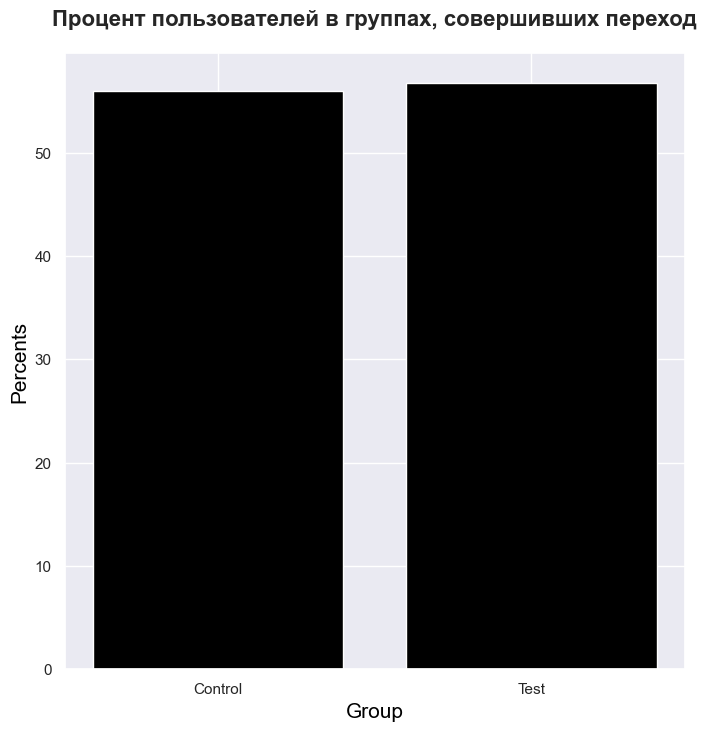

In [538]:
# Расчет процента конверсии для контрольной и тестовой группы
conversion_rate_control = m1_conversions_control / m1_total_user_control * 100
conversion_rate_test = m1_conversions_test / m1_total_user_test * 100


conversion_data = {'Group': ['Control', 'Test'],
                   'percent_of_conversion': [conversion_rate_control, conversion_rate_test]}

conversion_df = pd.DataFrame(conversion_data)

fig, ax = plt.subplots(figsize=(8,8))

plt.bar(conversion_df['Group'], conversion_df['percent_of_conversion'], color='black')

plt.xlabel('Group', fontsize=15, color='black')
plt.ylabel('Percents', fontsize=15, color='black')

ax.set_title('Процент пользователей в группах, совершивших переход', fontsize=16,
              fontweight='bold', pad=20)

plt.show()

## Ретеншн 2-го дня

In [9]:
metric_2 = metric_2.drop_duplicates(subset=['date', 'uuid']) # Фильтрация уникальных значений uuid для каждого дня

In [10]:
def conversions_control(n):                          #функция подсчёта ретеншена для контрольной группы
    day_start = metric_2['uuid'][metric_2['date'] == f'2023-03-{n}'].tolist()
    conversion = []
    if n > 11:
        for _ in range(n-11):
            conversion.append(None)
    for i in range(n, 18):
        conversion_day_1 = []
        day = metric_2['uuid'][metric_2['date'] == f'2023-03-{i}'][metric_2['group'] == 0].tolist()
        for uuid in day_start:
            if uuid in day:
                conversion_day_1.append(int(uuid))
        conversion.append(len(conversion_day_1))
    return conversion

In [11]:
def conversions_test(n):                          #функция подсчёта ретеншена для тестовой группы
    day_start = metric_2['uuid'][metric_2['date'] == f'2023-03-{n}'].tolist()
    conversion = []
    if n > 11:
        for _ in range(n-11):
            conversion.append(None)
    for i in range(n, 18):
        conversion_day_1 = []
        day = metric_2['uuid'][metric_2['date'] == f'2023-03-{i}'][metric_2['group'] == 1].tolist()
        for uuid in day_start:
            if uuid in day:
                conversion_day_1.append(int(uuid))
        conversion.append(len(conversion_day_1))
    return conversion

In [12]:
conversion_control_day_1 = conversions_control(11)
conversion_control_day_2 = conversions_control(12)
conversion_control_day_3 = conversions_control(13)
conversion_control_day_4 = conversions_control(14)
conversion_control_day_5 = conversions_control(15)
conversion_control_day_6 = conversions_control(16)
conversion_control_day_7 = conversions_control(17)

In [13]:
conversion_test_day_1 = conversions_test(11)
conversion_test_day_2 = conversions_test(12)
conversion_test_day_3 = conversions_test(13)
conversion_test_day_4 = conversions_test(14)
conversion_test_day_5 = conversions_test(15)
conversion_test_day_6 = conversions_test(16)
conversion_test_day_7 = conversions_test(17)

In [14]:
df = pd.DataFrame(conversion_test_day_1).T
df.loc[ len(df)] = conversion_test_day_2
df.loc[ len(df)] = conversion_test_day_3
df.loc[ len(df)] = conversion_test_day_4
df.loc[ len(df)] = conversion_test_day_5
df.loc[ len(df)] = conversion_test_day_6
df.loc[ len(df)] = conversion_test_day_7
df.columns = ['2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17']
df

,2023-03-11,2023-03-12,2023-03-13,2023-03-14,2023-03-15,2023-03-16,2023-03-17
0,4495.0,429.0,374.0,344.0,220.0,76.0,343.0
1,NaN,4366.0,404.0,367.0,230.0,82.0,324.0
2,NaN,NaN,4336.0,390.0,232.0,71.0,332.0
3,NaN,NaN,NaN,4190.0,285.0,85.0,337.0
4,NaN,NaN,NaN,NaN,3906.0,97.0,243.0
5,NaN,NaN,NaN,NaN,NaN,870.0,80.0
6,NaN,NaN,NaN,NaN,NaN,NaN,5406.0


In [15]:
dff = pd.DataFrame(conversion_control_day_1).T
dff.loc[ len(dff)] = conversion_control_day_2
dff.loc[ len(dff)] = conversion_control_day_3
dff.loc[ len(dff)] = conversion_control_day_4
dff.loc[ len(dff)] = conversion_control_day_5
dff.loc[ len(dff)] = conversion_control_day_6
dff.loc[ len(dff)] = conversion_control_day_7
dff.columns = ['2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17']
dff

,2023-03-11,2023-03-12,2023-03-13,2023-03-14,2023-03-15,2023-03-16,2023-03-17
0,4595.0,417.0,387.0,322.0,235.0,54.0,326.0
1,NaN,4304.0,411.0,337.0,246.0,59.0,321.0
2,NaN,NaN,4393.0,382.0,251.0,51.0,347.0
3,NaN,NaN,NaN,4224.0,290.0,54.0,308.0
4,NaN,NaN,NaN,NaN,3893.0,75.0,260.0
5,NaN,NaN,NaN,NaN,NaN,860.0,57.0
6,NaN,NaN,NaN,NaN,NaN,NaN,5235.0


In [18]:
control_conversion = []
test_conversion = []
for i in range(5):
    if i != 3:
        control_conversion.append(dff.iloc[i, i+2] / dff.iloc[i, i])
        test_conversion.append(df.iloc[i, i+2] / df.iloc[i, i])
        count = np.array([dff.iloc[i, i+2], df.iloc[i, i+2]])
        nobs = np.array([dff.iloc[i, i], df.iloc[i, i]])
        z_score, p_value = snss.proportions_ztest(count, nobs, value=0, alternative='two-sided')
        print(p_value)

0.8608609808530691
0.3262722974448671
0.45817753814088524
0.410884349360221


In [476]:
_, p2 = stats.ttest_ind(control_conversion,      # Применяем Т-тест
                test_conversion,
                equal_var=False)

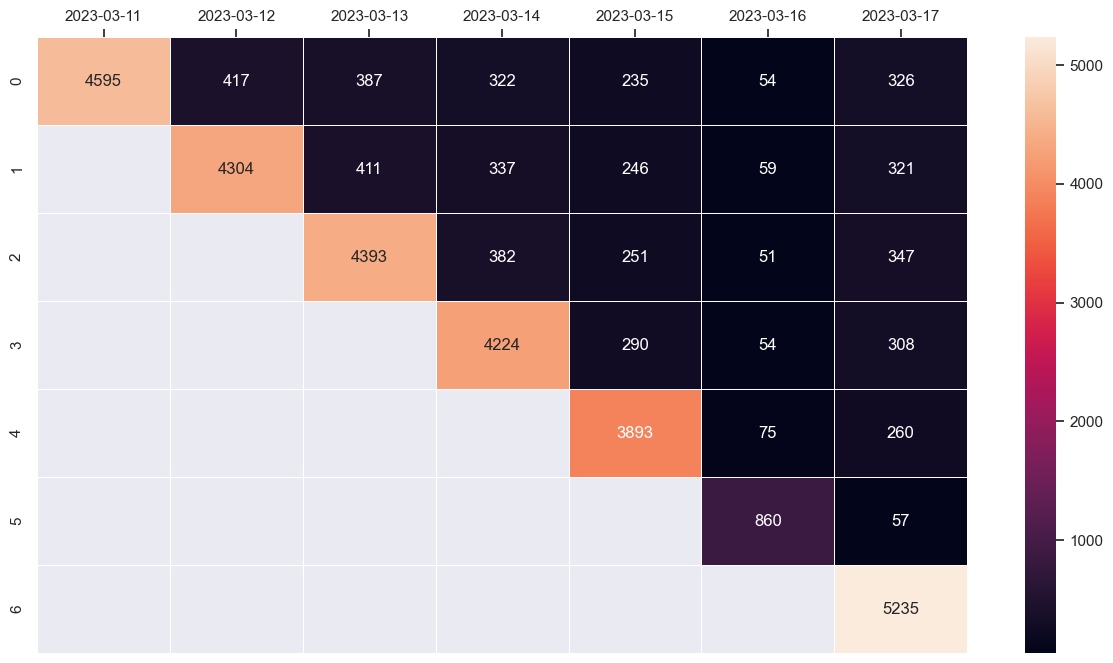

In [20]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(dff, annot=True, linewidth=.5, fmt='g')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

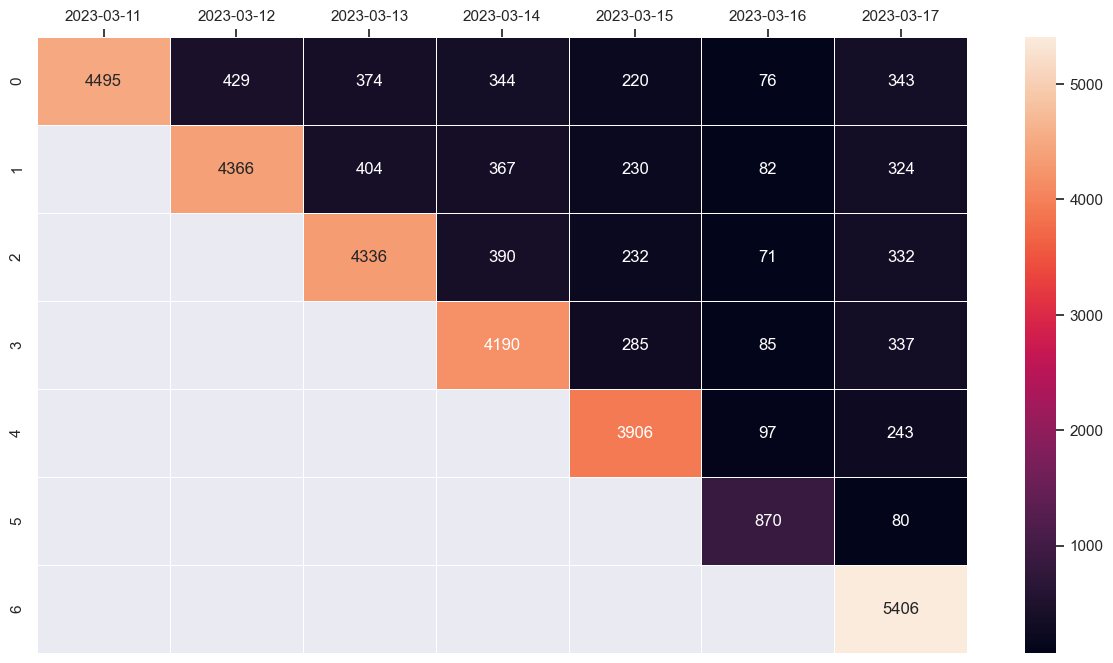

In [21]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(df, annot=True, linewidth=.5, fmt='g')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

## Конверсия с главной страницы отзывов

In [458]:
HTTP_REFERER = 'https://www.drom.ru/reviews/'  # создаём переменную со значением реферальной ссылки
                                                                # и словарь со всеми марками автомобилей
BRAND = ['ac', 'aito', 'acura', 'alfa_romeo', 'alpina', 'aro', 'asia', 'aston_martin', 'audi', 'baic', 'baw', 'bmw',
         'byd', 'bentley', 'brilliance', 'bugatti', 'buick', 'cadillac', 'changan', 'chery', 'chevrolet', 'chrysler',
         'citroen', 'cupra', 'dw_hower', 'dacia', 'dadi', 'daewoo', 'daihatsu', 'daimler', 'datsun', 'delorean',
         'derways', 'dodge', 'dongfeng', 'cheryexeed', 'eagle', 'evolute', 'faw', 'ferrari', 'fiat', 'fisker', 'ford',
         'foton', 'freightliner', 'gac', 'gmc', 'geely', 'genesis', 'geo', 'great_wall', 'hafei', 'haima', 'haval',
         'hawtai', 'hino', 'honda', 'hongqi', 'howo', 'hummer', 'hyundai', 'infiniti', 'iran_khodro', 'isuzu', 'jac',
         'jaguar', 'jeep', 'jetour', 'kaiyi', 'kia', 'koenigsegg', 'lamborghini', 'lancia', 'land_rover', 'lexus',
         'li', 'lifan', 'lincoln', 'lotus', 'luxgen', 'mini', 'marussia', 'maserati', 'maxus', 'maybach', 'mazda',
         'mclaren', 'mercedes-benz', 'mercury', 'mitsubishi', 'mitsuoka', 'nissan', 'omoda', 'oldsmobile', 'opel',
         'pagani', 'peugeot', 'plymouth', 'pontiac', 'porsche', 'proton', 'ram', 'ravon', 'renault', 'renault_samsung',
         'rivian', 'rolls-royce', 'rover', 'seat', 'saab', 'saturn', 'scion', 'skoda', 'skywell', 'smart', 'ssang_yong',
         'subaru', 'suzuki', 'tvr', 'tank', 'tesla', 'tianye', 'toyota', 'volkswagen', 'volvo', 'vortex', 'weltmeister',
         'wiesmann', 'xin_kai', 'zx', 'zotye', 'bogdan', 'gaz', 'zaz', 'zil', 'izh', 'lada', 'luaz', 'moskvitch',
         'tagaz', 'uaz']

In [459]:
metric_3 = metric_3.loc[metric_3['http_referer'] == HTTP_REFERER] # Фильтрация таблицы по http_referer

In [460]:
def uri(link):                 # Функция для обработки ссылки
    link = str(link)
    list1 = link.split("/")
    list1 = list(filter(None, list1))
    if 'reviews' in list1 and list1[-1] in BRAND and list1[-2] not in BRAND:
        return 1
    else:
        return 0

In [461]:
metric_3['converted'] = metric_3['uri'].apply(uri) # Создаем новый столбец, где 1 - есть конверсия, 0 - нет

In [463]:
m3_mask1 = (metric_3['group'] == 0)              # Количество перешедших и их общее количество для контрольной группы
m3_conversion_0 = metric_3['converted'][m3_mask1].to_numpy() # Создаём нампаевский массив для с конверсией для контрольной группы
m3_conversions_control = int(metric_3['converted'][m3_mask1].sum())
m3_total_user_control = int(metric_3['converted'][m3_mask1].count())
print(m3_conversions_control, m3_total_user_control)

9512 11706


In [464]:
m3_mask2 = (metric_3['group'] == 1)                  # Количество перешедших и их общее количество для тестовой группы
m3_conversion_1 = metric_3['converted'][m3_mask2].to_numpy() # Создаём нампаевский массив для с конверсией для тестовой группы
m3_conversions_test = int(metric_3['converted'][m3_mask2].sum())
m3_total_user_test = int(metric_3['converted'][m3_mask2].count())
print(m3_conversions_test, m3_total_user_test)

9279 11607


In [465]:
print('Соотношение контрольной и тестовой группы:', round(m3_total_user_control / metric_3['converted'].count() * 100, 2), "%",
      round(m3_total_user_test / metric_3['converted'].count() * 100, 2), "%")

Соотношение контрольной и тестовой группы: 50.21 % 49.79 %


In [466]:
count = np.array([m3_conversions_control, m3_conversions_test])
nobs = np.array([m3_total_user_control, m3_total_user_test])
z_score, p_value = snss.proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(p_value)

0.011160301156558543


In [467]:
def bootstrap(m3_conversion_0, m3_conversion_1, n_bootstrap=3000): #Создаём функцию bootstrap

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (2000, len(m3_conversion_0))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (2000, len(m3_conversion_1))).astype(np.int64)
    
    conversion_control = (poisson_bootstraps1*m3_conversion_0).sum(axis=1) / len(m3_conversion_0)
    
    conversion_test = (poisson_bootstraps2*m3_conversion_1).sum(axis=1) / len(m3_conversion_1)

    return conversion_control, conversion_test

In [468]:
cnvrs0, cnvrs1 = bootstrap(m3_conversion_0, m3_conversion_1)

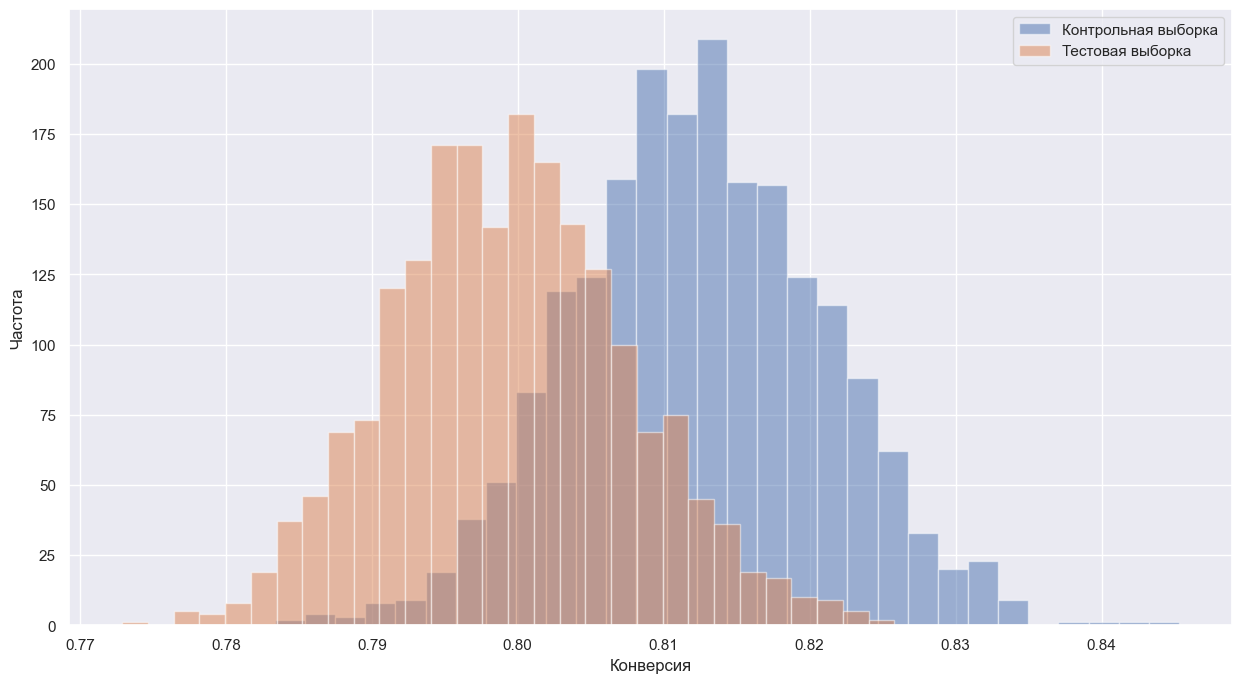

Ttest_indResult(statistic=48.787011450287004, pvalue=0.0)
[0.8212028  0.80975568 0.81838373 ... 0.81060994 0.81821288 0.80796173] [0.80615146 0.79615749 0.79624365 ... 0.7972775  0.79469286 0.8041699 ]


In [469]:
plt.hist(cnvrs0, bins=30, alpha=0.5, label='Контрольная выборка')
plt.hist(cnvrs1, bins=30, alpha=0.5, label='Тестовая выборка')
plt.xlabel('Конверсия')
plt.ylabel('Частота')
plt.legend()
plt.show()

print(stats.ttest_ind(cnvrs0, cnvrs1, equal_var=False))
print(cnvrs0, cnvrs1)

In [493]:
_, p3 = stats.ttest_ind(cnvrs0,      # Применяем Т-тест
                cnvrs1,
                equal_var=False,
                   alternative='two-sided')

In [494]:
p3

0.0

In [472]:
cnvrs0.mean(), cnvrs1.mean() # 0.812517127968563, 0.7991309123804601

(0.8123342303092431, 0.7994669595933489)

In [244]:
print('p-value:', p_value)
p3 = p_value

p-value: 0.011160301156558543


In [66]:
print(p3, 'Вторая метрика')
print(p3 > 0.05)

0.009394972687726509 Вторая метрика
False


In [486]:
z_score, p_value = snss.proportions_ztest(0.812, 0.799, value=0, alternative='two-sided')

In [488]:
z_score

nan

In [484]:
m3_conversions_control / m3_total_user_control

0.8125747479924825

In [485]:
m3_conversions_test / m3_total_user_test

0.7994313776169553

## Поправка Бонферрони

In [474]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [477]:
pval = [p1, p2, p3]
print(pval)

[0.009394972687726509, 0.9322089007527383, 0.0]


In [478]:
rejected, p_corrected, _, _ = multipletests(pval, alpha=0.05, method='bonferroni')
print(p_corrected)
print(p_corrected > 0.05)

[0.02818492 1.         0.        ]
[False  True False]
